# Land Cover Classification using Satellite Imagery and Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and pixel-based classification

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2">Introduction</a></span></li><li><span><a href="#Export-training-data-for-deep-learning" data-toc-modified-id="Export-training-data-for-deep-learning-3">Export training data for deep learning</a></span><li><span><a href="#Model-training" data-toc-modified-id="Model-training-4">Model training</a></span><ul class="toc-item"><li><span><a href="#Visualize-training-data" data-toc-modified-id="Visualize-training-data-4.1">Visualize training data</a></span></li><li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-4.2">Load model architecture</a></span></li>
    <li><span><a href="#Train-a-model" data-toc-modified-id="Train-a-model">Train a model</a></span></li>
    <li><span><a href="#Preview-Results" data-toc-modified-id="Preview-Results">Preview Results</a></span></li></ul></li>
    <li><span><a href="#Deploy-Model" data-toc-modified-id="Deploy-Model">Deploy-Model</a></span></li>
    <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8">References</a></span></li></ul></div>

## Introduction

Land cover classification has been one of the most common tasks in remote sensing as it is the foundation for many global and environmental applications. Traditionally, people have been using algorithms like maximum likelihood classifier, SVM, random forest, and object-based classification. The recent success of AI brings new opportunity to this field. This notebook showcases an end-to-end to land cover classification workflow using ArcGIS API for Python. The workflow consists of three major steps: (1) extract training data, (2) train a deep learning **image segmentation** model, (3) deploy the model for inference and create maps. To better illustrate this process, we will use World Imagery and high-resolution labeled data provided by the [Chesapeake Conservancy land cover project](https://chesapeakeconservancy.org/conservation-innovation-center/high-resolution-data/land-cover-data-project/).
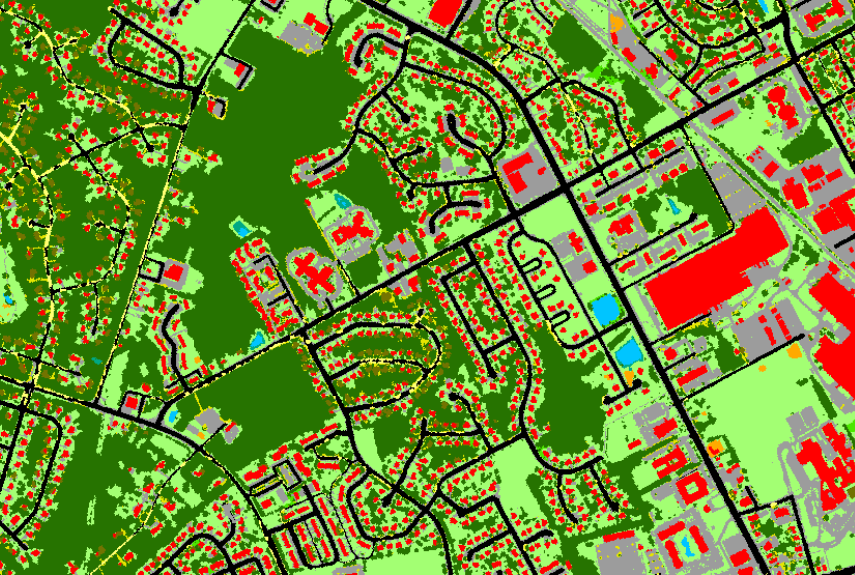
<center> Figure 1. A subset of of the labeled data for Kent county, Delaware

## Export training data for deep learning

Before using this tool make sure your imagery and classified raster are in unsigned 8bit format. You can check that by viewing source properties of the layers.

Export training data using 'Export Training data for deep learning' tool, [detailed documentation here](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm)
- Set the **Esri World Imagery** as 'Input Raster'.
- Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
- Set **Landcover classified raster** as 'Input Feature Class Or Classified Raster'.
- In the option 'Input Mask Polygons' we can set a mask layer to limit the tool to export training data for only those areas which we intent to train our model on.
- 'Tile Size X' & 'Tile Size Y' can be set.
- Select 'Classified Tiles' as the 'Meta Data Format' because we are training an 'Unet Model'.
- In 'Environments' tab set an optimum 'Cell Size'. For this example we used 1 cell size which meant **1 meter** on the project coordinate system. 


<div>

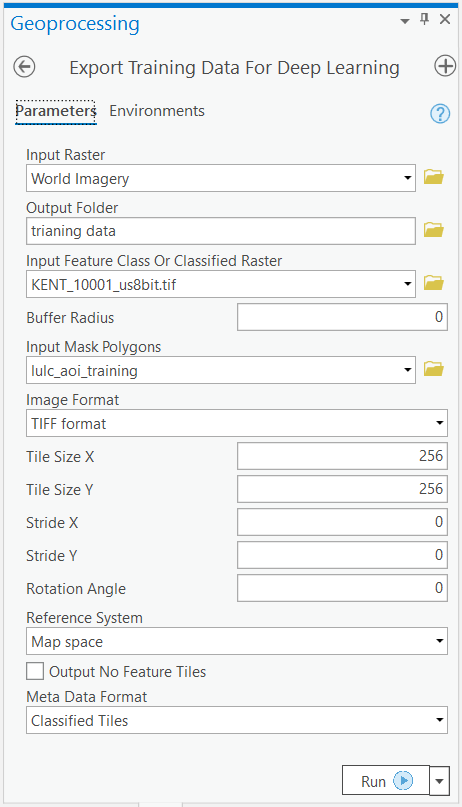
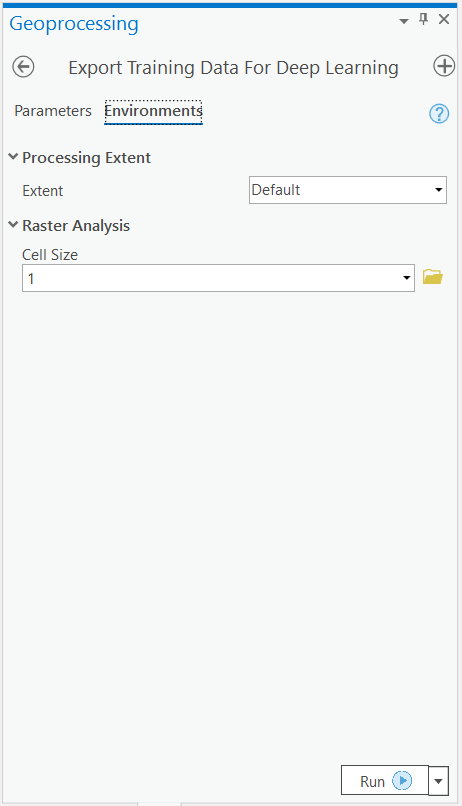
</div>

This will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our **training data**.

## Model training

In [4]:
from arcgis.learn import UnetClassifier, prepare_data

### Prepare Data

The `prepare_data` function takes in the training data and applies various types of transformations and augmentations. We would now use this function and specify the path to our training data and a few parameters to create a fastai databunch. 

`path`: path of folder containing training data.<br/>
`batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a GPU with 11GB memory.

In [6]:
data = prepare_data('training_data_lulc_256px_1m', 
                    batch_size=8)

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them.

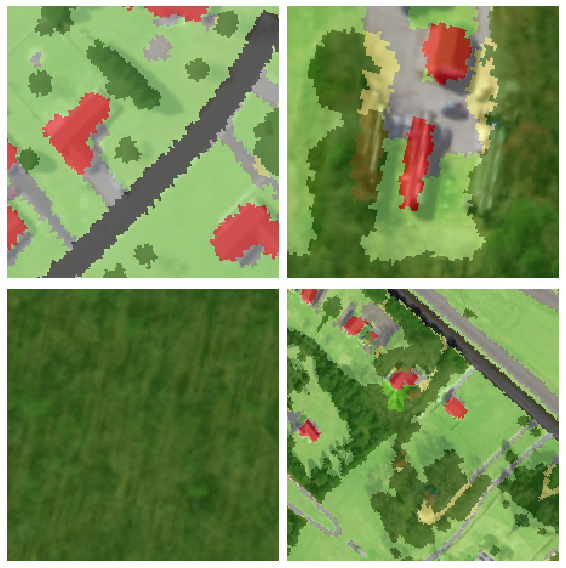

In [8]:
data.show_batch()

### Load model architecture
We will be using U-net, one of the well-recogonized image segmentation algorithm, for our land cover classification. U-Net is designed like an auto-encoder. It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape. However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?”. U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path.  These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.

<center>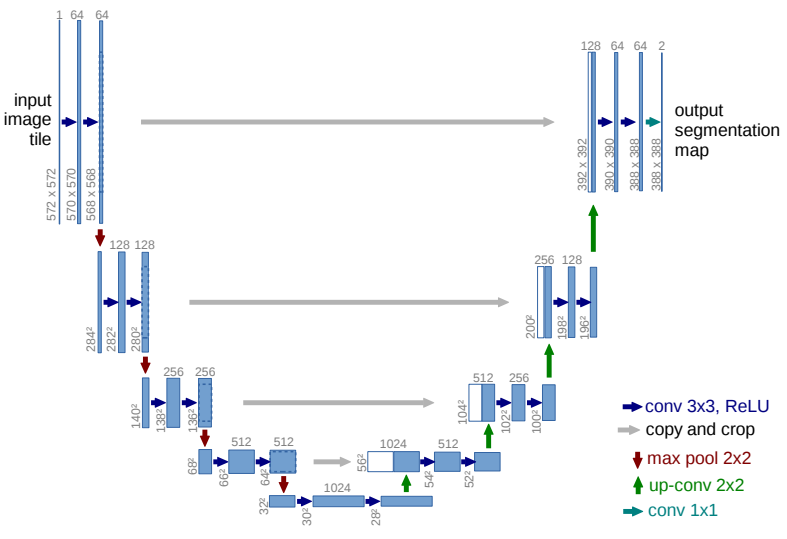 </center>
<center>Figure 2. Architecture of a Unet model [1]</center>

In [9]:
model = UnetClassifier(data)

### Train a model
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Here we explore a range of learning rate to guide us to choose the best one.

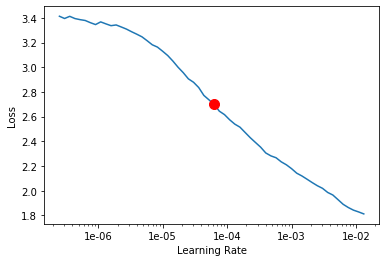

6.309573444801929e-05

In [11]:
model.lr_find()

Based on the learning rate plot above, we can see that the loss going down dramatically at 1e-6. Therefore, we set learning rate to be a 1e-4.

In [15]:
model.fit(10, lr=1e-4, checkpoint=False)

epoch,train_loss,valid_loss,accuracy,time
0,0.556339,0.690357,0.814773,00:15
1,0.616848,0.677527,0.807280,00:17
2,0.615149,0.667149,0.809299,00:17
3,0.602290,0.720925,0.787367,00:17
4,0.589283,0.663084,0.818398,00:17
5,0.574731,0.746323,0.811237,00:17
6,0.578497,0.655046,0.822539,00:17
7,0.559896,0.602593,0.824976,00:16
8,0.529325,0.615497,0.826117,00:16
9,0.517030,0.615308,0.825786,00:17


### Save the model

We will save the model which we just trained as a '**Deep Learning Package**' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. `UnetClassifier` models can be deployed by the tool 'Classify Pixels Using Deep Learning' available in <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">ArcGIS Pro</a> as well as <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">ArcGIS Enterprise</a>. For this sample we will using this model in ArcGIS Pro to extract building footprints.

We will use the `save()` method to save the model and by default it will be saved to a folder '**models**' inside our training data folder itself.

In [16]:
# Save model to file
model.save('10e')

WindowsPath('training_data_lulc_256px_1m/models/10e')

### Preview Results
Now we have the model, let's look at how the model performs.

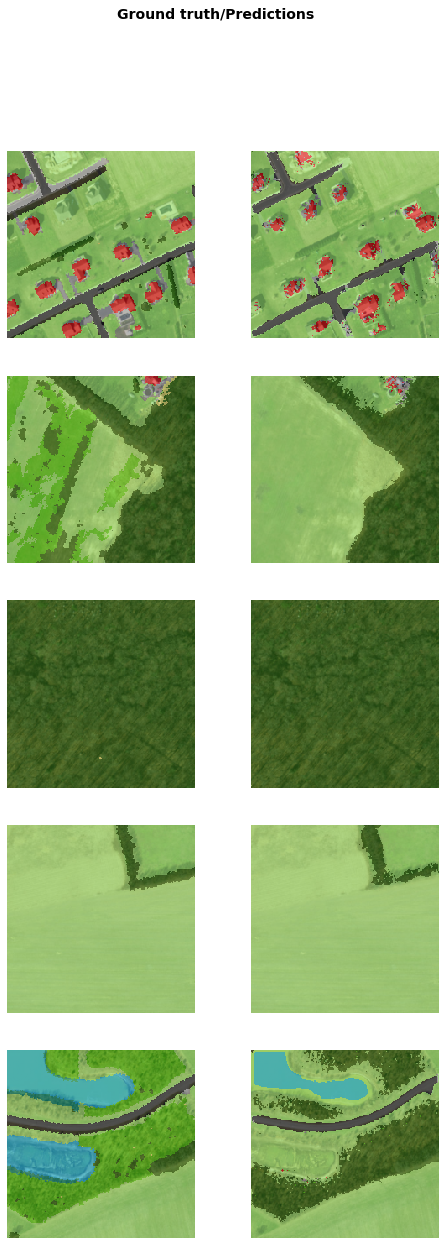

In [17]:
model.show_results()

## Deploy Model

The deep learning package saved in previous step can be used to extract classified raster using '**Classify Pixels Using Deep Learning**' tool.


#### Generate a Classified Raster using 'Classify Pixels Using Deep Learning tool'

In this step we will generate a classified raster using 'Classify Pixels Using Deep Learning' tool available in both [**ArcGIS Pro**](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) and [**ArcGIS Enterprise**](https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm).

- **Input Raster**: The raster layer from which we want to extract building footprints from.
- **Model Definition**: It will be located inside the saved model in 'models' folder in '.emd' format.
- **padding**: The 'Input Raster' is tiled and the deep learning model classifies each individual tile separately before producing the final '**Output Classified Raster**'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.  
- **Processing Extent**: Set it to an extent at which you want to want to limit the tool's ouput to.
- **Cell Size**: Should be close to at which we trained the model, we specified that at the [Export training data step]("#Export-training-data") .
- **Processor Type**: This allows to control whether the system's '**GPU**' or '**CPU**' would be used in to classify pixels, by 'default GPU' will be used if available.
- **Parallel Processing Factor**: This allows us to scale this tool, this tool can be scaled on both 'CPU' and 'GPU'. It specifies that the operation would be spread across how many '**cpu cores**' in case of cpu based operation or '**no of GPU's**' incase of GPU based operation.

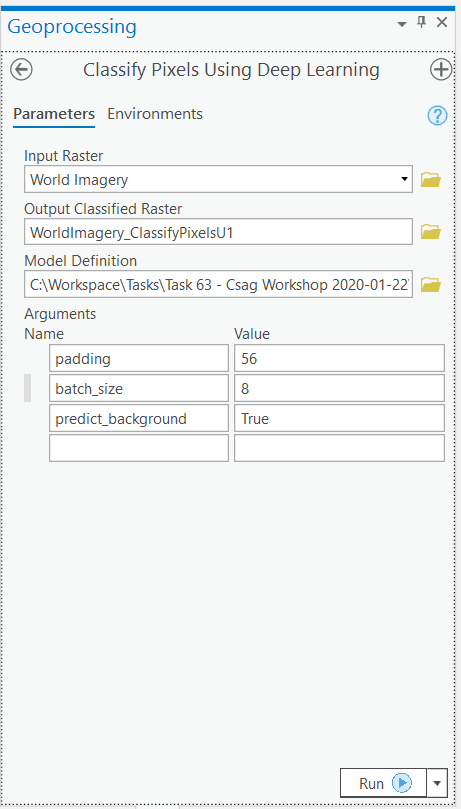
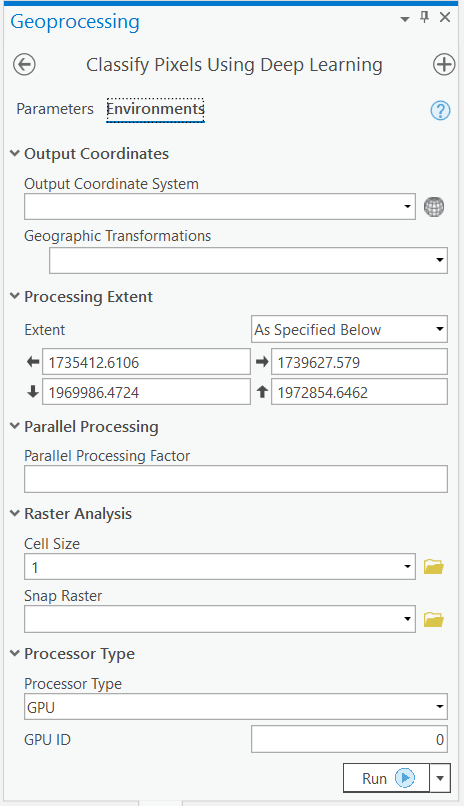

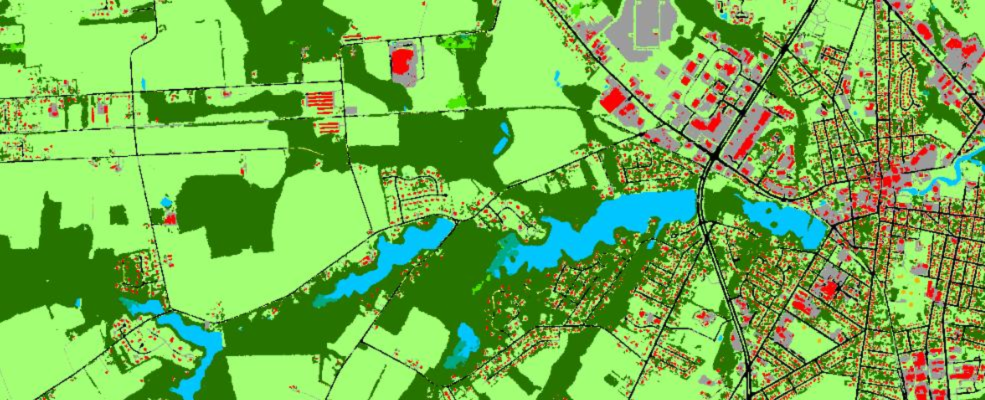

<center>Sample Results</center>

## Conclusion
In this notebook, we have covered a lot of ground. We discussed how to export training data for deep learning and what the output looks like. We also demonstrated how to prepare the input data, train a pixel-based classification model, visualize the results, as well as apply the model to an unseen image.

## References
[1] Olaf Ronneberger, Philipp Fischer, Thomas Brox: U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015; <a href='https://arxiv.org/abs/1505.04597'>arXiv:1505.04597</a>.